In [1]:
import h5py
import pylab as pl
import numpy as np
import matplotlib.colors as mpc
import networkx
import ipyvolume as ipv

In [2]:
pl.rc('font', size = 20)
pl.rc('legend', fontsize = 20)

In [3]:
def split_unique_id(unique_id):
    """Splits the ids assign to the subhalos by the merger tree code by snap number and subfind number """
    subfind_number = int(unique_id % 1e6)
    snap_number = int((unique_id - subfind_number) / 1e6)
    
    return snap_number, subfind_number

def get_main_branch_unique_ids(subtree, node):
    """Gets the unique ids of the subhalos belonging to the main branch of the selected subhalo (node)"""
    mpb = [node, ]
    i = 0
    while True:
        succesors = list(subtree.successors(node))
        if len(succesors) == 0:
            break
        node = succesors[0] # select only the first succesor (main branch)
        mpb.append(node)
        
    return mpb

def get_main_branch_and_progNumb(subtree, node):
    """Gets the unique ids of the subhalos belonging to the main branch of the selected subhalo (node)"""
    mpb = [node, ]
    numb = [[node], ]
    i = 0
    while True:
        successors = list(subtree.successors(node))
        if len(successors) == 0:
            break
        node = successors[0] # select only the first succesor (main branch)
        mpb.append(node)
        numb.append(successors)
        
    return mpb, numb


def set_view(figure, framenr, fraction):
    ipv.view(fraction*360, 0.)
    
def set_angles(fig, i, fraction):
    fig.angley = fraction*np.pi*2

# a bunch of constants
UnitMass_in_g = 1.989e+43
UnitTime_in_s = 3.08568e+16
UnitVelocity_in_cm_per_s = 100000
UnitDensity_in_cgs = 6.7699e-22
UnitEnergy_in_cgs = 1.989e+53
GAMMA_MINUS1 = 2./3.
PROTONMASS = 1.6726e-24
BOLTZMANN = 1.3806e-16    

def tempFromMass(Mass, Abund, IE, ne1):
    XH = Abund[:,6]/Mass
    yHelium = (1. - XH)/(4.*XH)
    mu = (1 + 4.* yHelium)/ (1.+ yHelium + ne1 )
    temp = GAMMA_MINUS1 * IE * mu * 1.6726 / 1.3806 * 1.e-8 # / BOLTZMANN  * PROTONMASS
    temp = temp * 1e10 #   UnitEnergy_in_cgs / UnitMass_in_g;
    return temp




In [4]:
sim = h5py.File('/data/cielo/simulations/LG1/LG1.hdf5', 'r')
trees = networkx.read_multiline_adjlist('/data/cielo/simulations/LG1/LG1_tree.dat')

In [5]:
def plotPhaseSpace(fofID, centralID):
    uniqueID = int(128*1e6+fofID)
    stree = networkx.dfs_tree(trees, str(uniqueID))
    mtree, numbs = get_main_branch_and_progNumb(stree, str(uniqueID))
    
    uniqueC = int(128*1e6+centralID)
    streeC = networkx.dfs_tree(trees, str(uniqueC))
    mtreeC = get_main_branch_unique_ids(streeC, str(uniqueC))
    
    # find all the particleIDs that once belong to the subgroup
#     Idlist, vallist, valcen = [], [], []
    Idlist, vallist = [], []
    
    
    for mm, mmC in zip(mtree[1:], mtreeC[1:]): # ignore the first one
        snap, idd = split_unique_id(int(mm))
        snapC, iddC = split_unique_id(int(mmC))
        tempOff = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][idd].astype('int')
        pgal = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]
        if snapC==snap:
            pcen = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snapC)][iddC]
        if tempOff[0]>= 0 and tempOff[1]>=0:
            tempIds = sim['SnapNumber_{}/PartType0/ParticleIDs'.format(snap)][tempOff[0]:tempOff[1]]
            Idlist.extend(list(tempIds))
            # calcule the value for color coding the graph
            #val = sim['SnapNumber_{}/Header/Redshift'.format(snap)][()]
            IE = sim['SnapNumber_{}/PartType0/InternalEnergy'.format(snap)][tempOff[0]:tempOff[1]]
            Mass = sim['SnapNumber_{}/PartType0/Masses'.format(snap)][tempOff[0]:tempOff[1]]
            Abund = sim['SnapNumber_{}/PartType0/Abundances'.format(snap)][tempOff[0]:tempOff[1]]
            ne1 = sim['SnapNumber_{}/PartType0/ElectronAbundance'.format(snap)][tempOff[0]:tempOff[1]]
            val = tempFromMass(Mass, Abund, IE, ne1)
            #return None
            # if val is one for each particles just append, otherwise do the next
            #vallist.extend([val]*tempIds.size)
            # or
            vallist.extend(list(val))

    Idlist, vallist = np.array(Idlist), np.array(vallist)
    Idlist, Idunique = np.unique(Idlist, return_index=True) # remove duplicates
    vallist = vallist[Idunique]

    
    # the total list of particles that once belong to a give subgroup, lest see where are today.
    TdayOff = sim['SnapNumber_128/SubGroups/PartType0/Offsets'][fofID].astype('int')
    TdayCoord = sim['SnapNumber_128/PartType0/Coordinates'][TdayOff[0]:TdayOff[1]]

    TdayTotalIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][()]
    
    IndexToday = np.in1d(TdayTotalIDs, Idlist)
    IndexToday_ = np.where(IndexToday)[0]
    
    #remove the ones that are not part of the group today.
    TdayIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][TdayOff[0]:TdayOff[1]]

    IndexNot = np.in1d(Idlist, TdayIDs)
    IdNot = Idlist[np.where(IndexNot==False)[0]]

    IndexT = np.in1d(TdayTotalIDs, IdNot)
    IndexT_ = np.where(IndexT)[0]
    LostCoord = sim['SnapNumber_128/PartType0/Coordinates'][IndexT_]

    # ... and the redshift
    SurvIds_ = TdayTotalIDs[IndexT_]
    iidex = np.in1d(Idlist, SurvIds_)
    iidex_ = np.where(iidex)[0]
    vallist_, Idlist_ = vallist[iidex_], Idlist[iidex_]

    is1 = np.argsort(SurvIds_) # the target
    is2 = np.argsort(Idlist_)

    valorder = np.zeros(IndexT_.size)
    valorder[is1] = vallist_[is2]
    
    #now lets cut at  a certain distance
    distance = 600 # distance in ckpc

    posGal = sim['SnapNumber_128/SubGroups/SubGroupPos'][fofID]
    posCen = sim['SnapNumber_128/SubGroups/SubGroupPos'][centralID]

    dx, dy, dz = LostCoord[:,0]-posGal[0], LostCoord[:,1]-posGal[1], LostCoord[:,2]-posGal[2]
    distToC = np.sqrt(dx**2+dy**2+dz**2)

    icut = np.where(distToC<distance)[0]
    IndexT_near = IndexT_[icut]
    valorder_near = valorder[icut]
    #IndexT_near = IndexT_
    #valorder_near = valorder
    
    NearCoord = sim['SnapNumber_128/PartType0/Coordinates'][IndexT_near]
    NearVel = sim['SnapNumber_128/PartType0/Velocities'][IndexT_near]
    
    
    #Check if the remove of particles at z=0 works.
    
#     Ids_test = sim['SnapNumber_127/PartType0/ParticleIDs'][IndexT_near]
#     Ids_target = sim['SnapNumber_127/PartType0/ParticleIDs'][TdayOff[0]:TdayOff[1]]
    
#     itest = np.isin(Ids_target, Ids_test)
#     iitest = np.where(itest)[0]
    
#     print(iitest.size, 'maybe there is a problem')
    
    # ok, lest see velocity and stuff
    velSat = sim['SnapNumber_128/SubGroups/SubGroupVel'][fofID]
    
    xo, yo, zo = NearCoord[:,0], NearCoord[:,1], NearCoord[:,2]
    xoC, yoC, zoC = xo - posGal[0], yo - posGal[1], zo - posGal[2]
    
    vxo, vyo, vzo = NearVel[:,0], NearVel[:,1], NearVel[:,2]
    vxoC, vyoC, vzoC = vxo - velSat[0], vyo - velSat[1], vzo - velSat[2]

    #cenPx, cenPy, cenPz = galH[:,0] - posCen[0], galH[:,1] - posCen[1], galH[:,2] - posCen[2]
    #cenPx, cenPy, cenPz = galH[:,0] - cenH[:,0], galH[:,1] - cenH[:,1], galH[:,2] - cenH[:,2]

#     halfmass = sim['SnapNumber_127/SubGroups/SubGroupHalfMass'][fofID]
    veldisp = sim['SnapNumber_128/SubGroups/SubGroupVelDisp'][fofID]
    
    
#     G = 4.3009*1e-6 # in kpc km/s M_sun^-1
#     H = 0.1 # in km/s kpc^-1 h
#     halfmass = halfmass * 1e10 # in M_sun h^-1
    
#     halfdist = ((G*halfmass)/(100*H**2))**(1./3.) # in kpc
    halfdist = sim['SnapNumber_128/SubGroups/OpticalRadius'][fofID]
    
    rr = np.sqrt(xoC**2 + yoC**2 +zoC**2)
    rhm = rr/halfdist
    
    vv = np.sqrt(vxoC**2 + vyoC**2 + vzoC**2)
    vdisp = vv/veldisp
    
    # and the galaxy.
    GalCoords = sim['SnapNumber_128/PartType0/Coordinates'][TdayOff[0]:TdayOff[1]]
    GalVels = sim['SnapNumber_128/PartType0/Velocities'][TdayOff[0]:TdayOff[1]]
    
    galx, galy, galz = GalCoords[:,0] - posGal[0], GalCoords[:,1] - posGal[1], GalCoords[:,2] - posGal[2]
    galvx, galvy, galvz = GalVels[:,0] - velSat[0], GalVels[:,1] - velSat[1], GalVels[:,2] - velSat[2]
    
    rgal = np.sqrt(galx**2+galy**2+galz**2)
    rrgal = rgal/halfdist
    
    vgal = np.sqrt(galvx**2+galvy**2+galvz**2)
    vvgal = vgal/veldisp
    
    pl.figure(figsize=(14,14))
    
    valranges = np.linspace(0, 100, 11)
    vallims = np.percentile(valorder_near, valranges)
    
    norm = mpc.BoundaryNorm(boundaries=vallims, ncolors=256)
    
    pl.scatter(rhm, vdisp, marker='o', c=valorder_near, s=2, norm=norm)
    #pl.scatter(rhm, vdisp, marker='o', c=valorder_near, s=2, norm=mpc.LogNorm())
    
    #pl.scatter(rrgal, vvgal, marker='o', color='black', s=2)
    
    pl.xlabel('$r/r_{optical}$')
    pl.ylabel('velocity/$\sigma$')
    
    bar = pl.colorbar()
    
    bar.set_ticks(vallims)
#    bar.set_label('z')
#     bar.set_label('Internal Energy [km²/s²]')
    bar.set_label('Temperature/K')

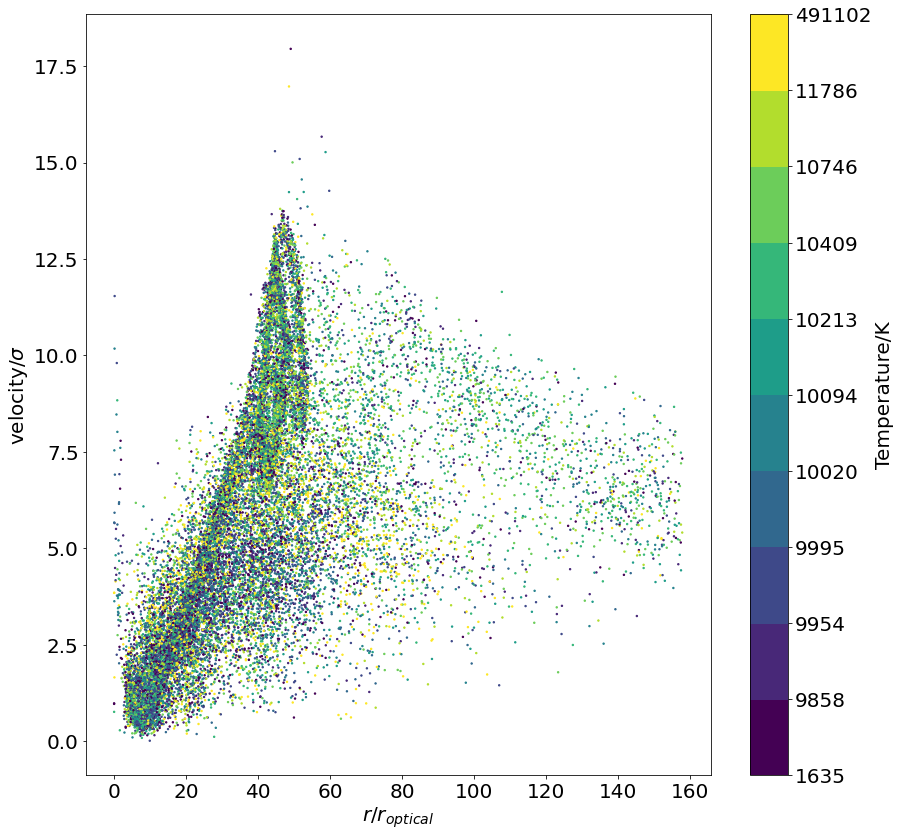

In [6]:
#  4338, 4341 (4337), 4470 y 4474 (4469)
plotPhaseSpace(4338,4337)

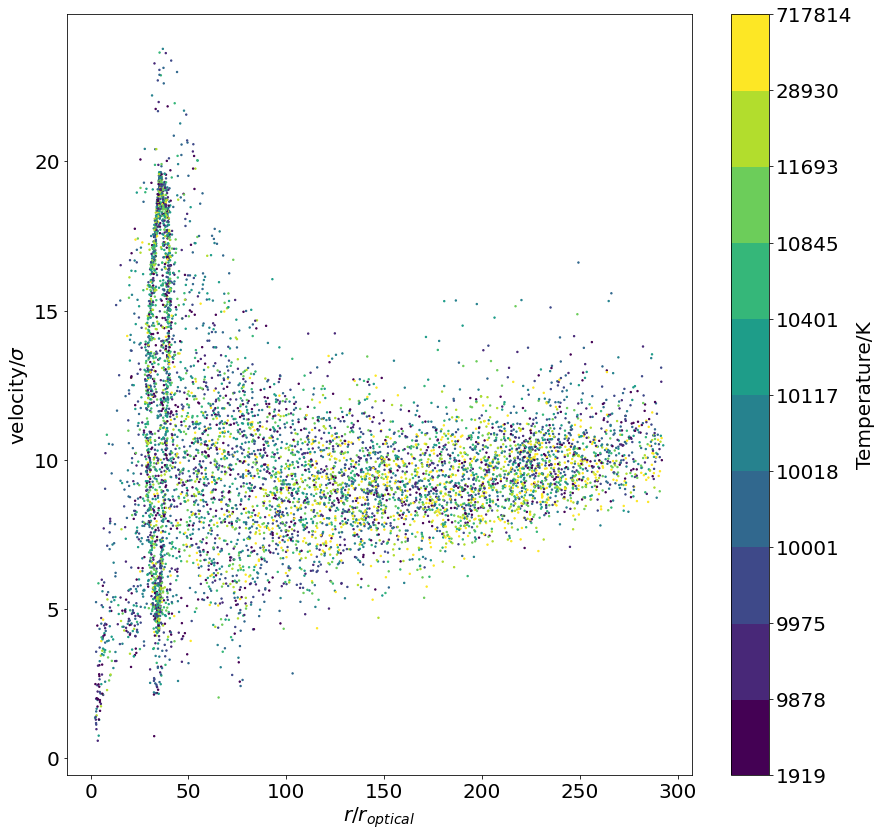

In [7]:
plotPhaseSpace(4339,4337)

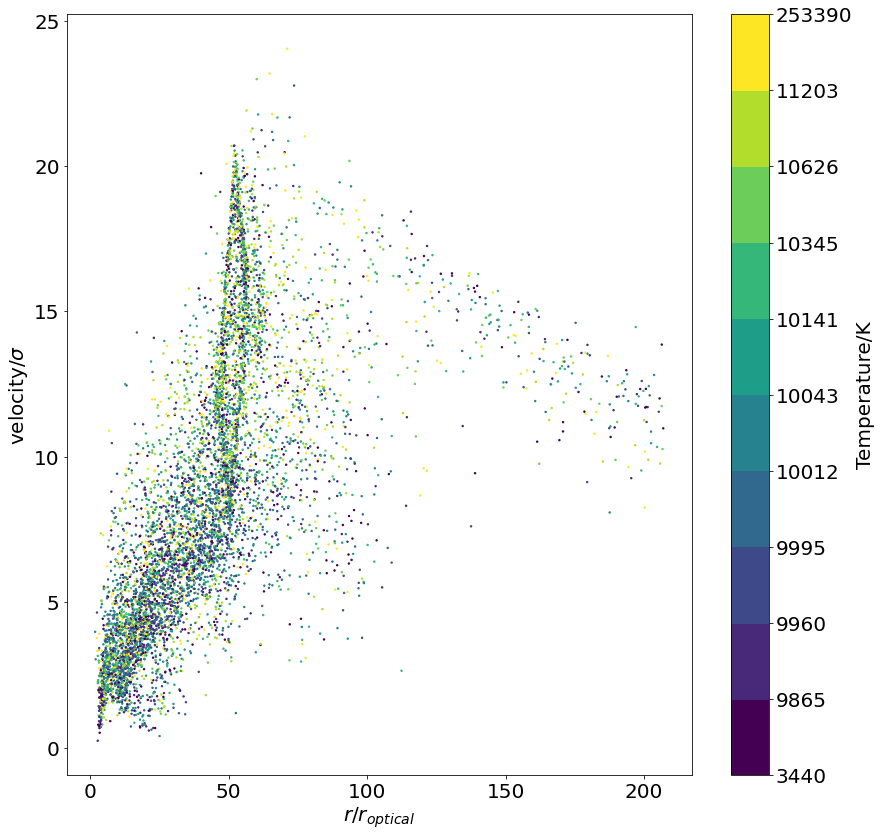

In [8]:
plotPhaseSpace(4341,4337)

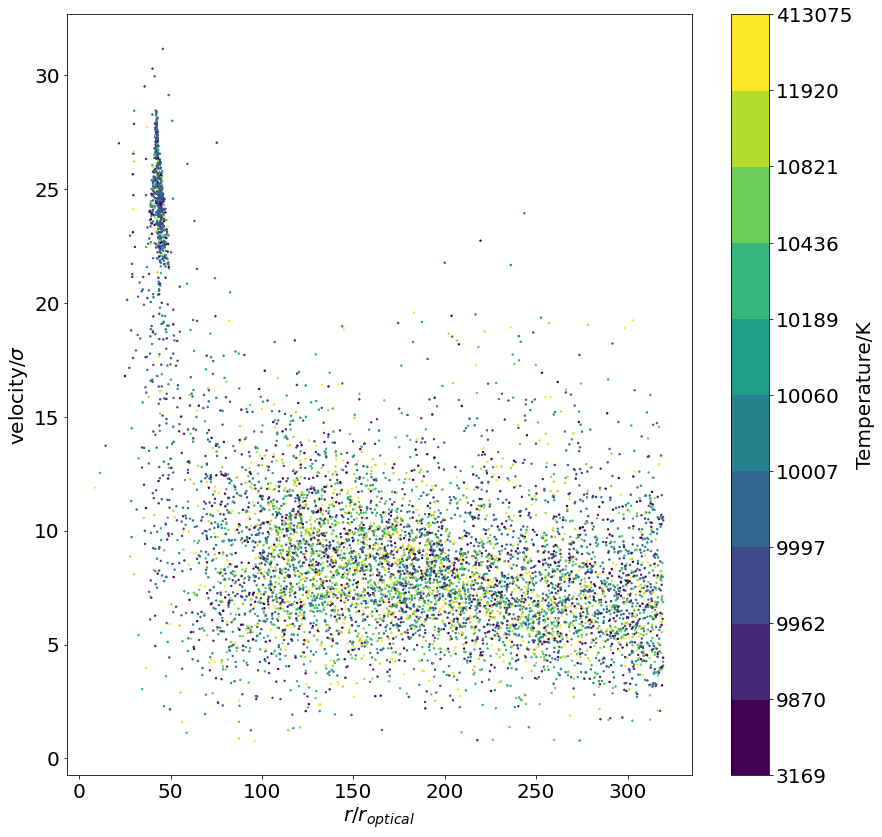

In [9]:
plotPhaseSpace(4343,4337)

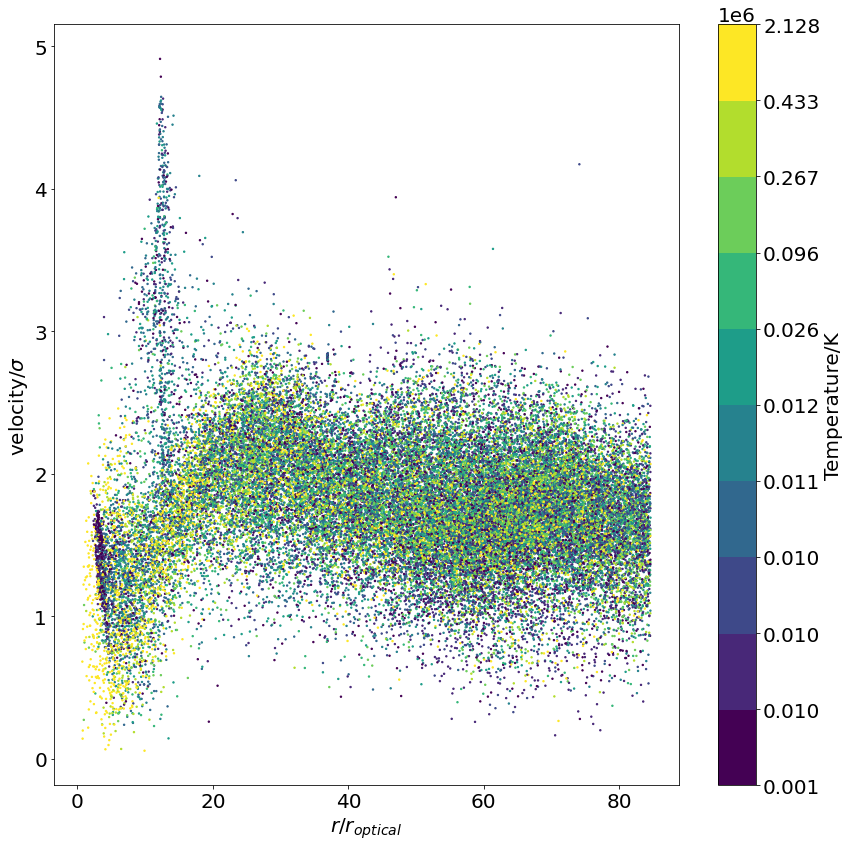

In [10]:
plotPhaseSpace(4470,4469)

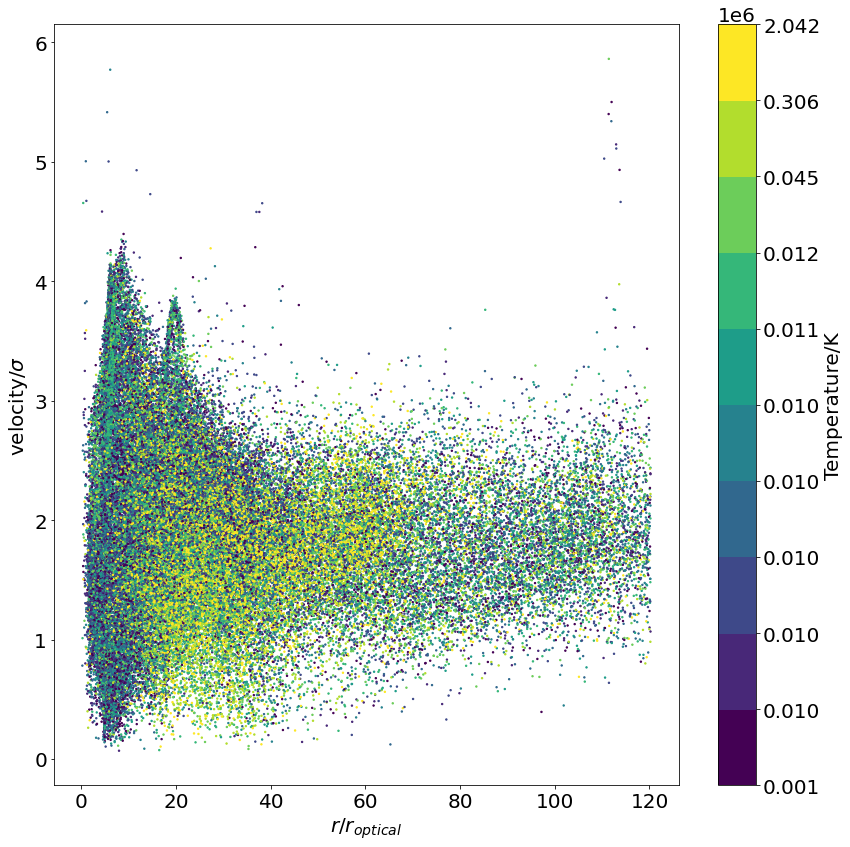

In [11]:
plotPhaseSpace(4471,4469)

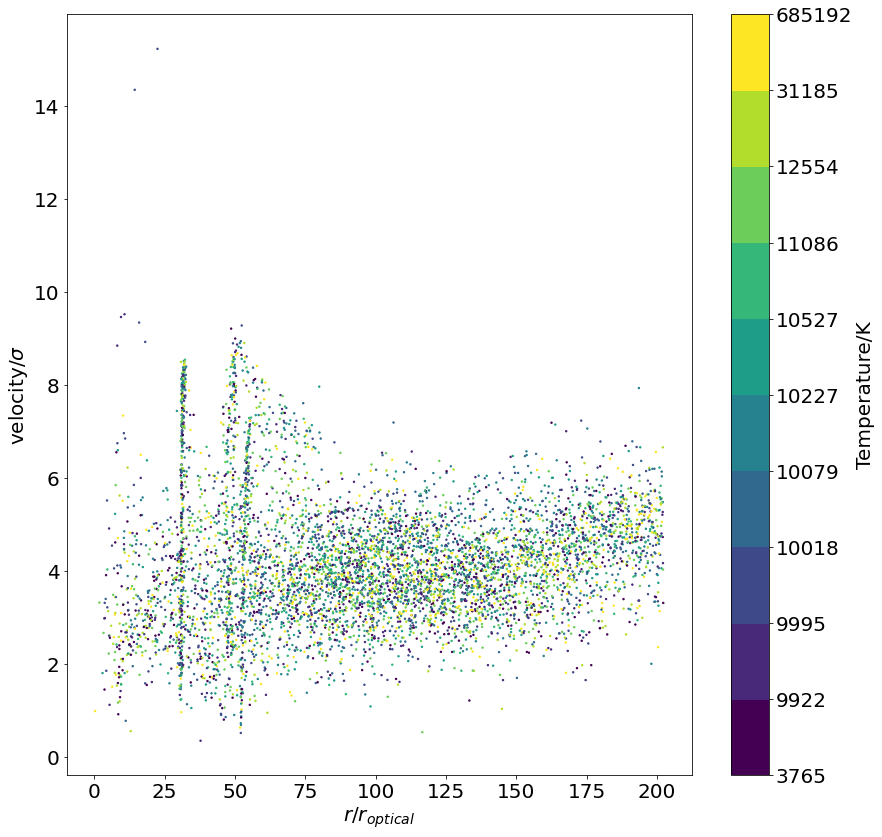

In [12]:
plotPhaseSpace(4473,4469)

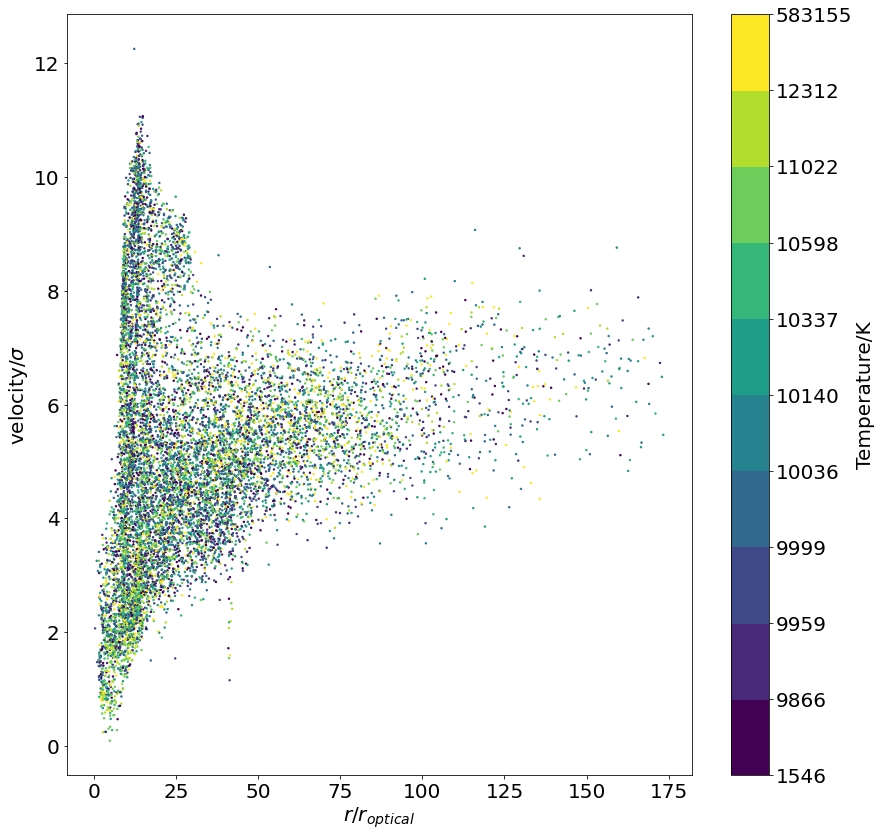

In [13]:
plotPhaseSpace(4474,4469)

In [14]:
sim['SnapNumber_128/PartType0/InternalEnergy'].attrs.keys()

<KeysViewHDF5 ['cgs_conversion_factor', 'cgs_units', 'description', 'description_units']>

In [15]:
sim['SnapNumber_128/PartType0/InternalEnergy'].attrs['description_units']

'$km^{2} s^{-2}$'

In [16]:
sim['SnapNumber_128/PartType0/'].keys()

<KeysViewHDF5 ['Abundances', 'BindingEnergy', 'Circularity', 'Coordinates', 'Density', 'ElectronAbundance', 'Esn', 'EsnCold', 'GroupNumber', 'InternalEnergy', 'Masses', 'NeutralHydrogenAbundance', 'ParticleIDs', 'Potential', 'SmoothingLength', 'SpecificAngularMomentum', 'StarFormationRate', 'SubFindNumber', 'SubGroupNumber', 'Velocities']>

In [17]:
sim['SnapNumber_128/Groups'].keys()

<KeysViewHDF5 ['Contamination', 'GroupCM', 'GroupLen', 'GroupLenType', 'GroupMassType', 'GroupNsubs', 'GroupNumber', 'GroupSFR', 'Group_M_Crit200', 'Group_M_Mean200', 'Group_M_TopHat200', 'Group_R_Crit200', 'Group_R_Mean200', 'Group_R_TopHat200', 'PartType0', 'PartType1', 'PartType4', 'PartType5', 'SnapNumber']>